# Importar librerías y módulos relevantes

In [1]:
# Esenciales
import pandas as pd
import numpy as np
# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
# ML y Modelado
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import xgboost as xgb
import optuna
# Explicabilidad del Modelo
import shap
# Almacenar el Modelo
import pickle
from pathlib import Path

# Cargar datos desde SQL

In [2]:
df = pd.read_csv("../data/procesado/data_feature_engineering.csv")

# Revisión exploratoria de los datos

## Confirmación de que los datos de extrajeron correctamente desde SQL

In [3]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,ratio_utilización_3,ratio_utilización_4,ratio_utilización_5,ratio_utilización_6,ratio_pago_1,ratio_pago_2,ratio_pago_3,ratio_pago_4,ratio_pago_5,default_payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.034450,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1
1,120000,2,2,2,26,-1,2,0,0,0,...,0.022350,0.027267,0.028792,0.027175,0.000000,0.372856,0.305623,0.289436,0.000000,1
2,90000,2,2,2,34,0,0,0,0,0,...,0.150656,0.159233,0.166089,0.172767,0.108220,0.110628,0.069779,0.066899,0.064313,0
3,50000,2,2,1,37,0,0,0,0,0,...,0.985820,0.566280,0.579180,0.590940,0.041465,0.040961,0.042382,0.037985,0.036180,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,0.716700,0.418800,0.382920,0.382620,0.352734,1.023608,0.477555,0.470072,0.036015,0


In [4]:
df.shape

(30000, 35)

# Visualización Exploratoria
Primero, usaré un gráfico de barras para ver rápidamente la proporción entre los datos que son declarados en default y los que no. Por otro lado, usaré un mapa de calor para revisar las correlaciones entre las características de la base de datos.

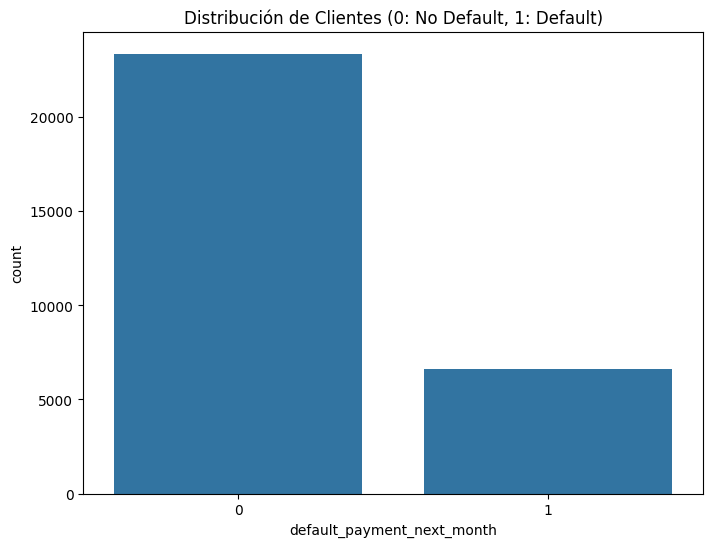

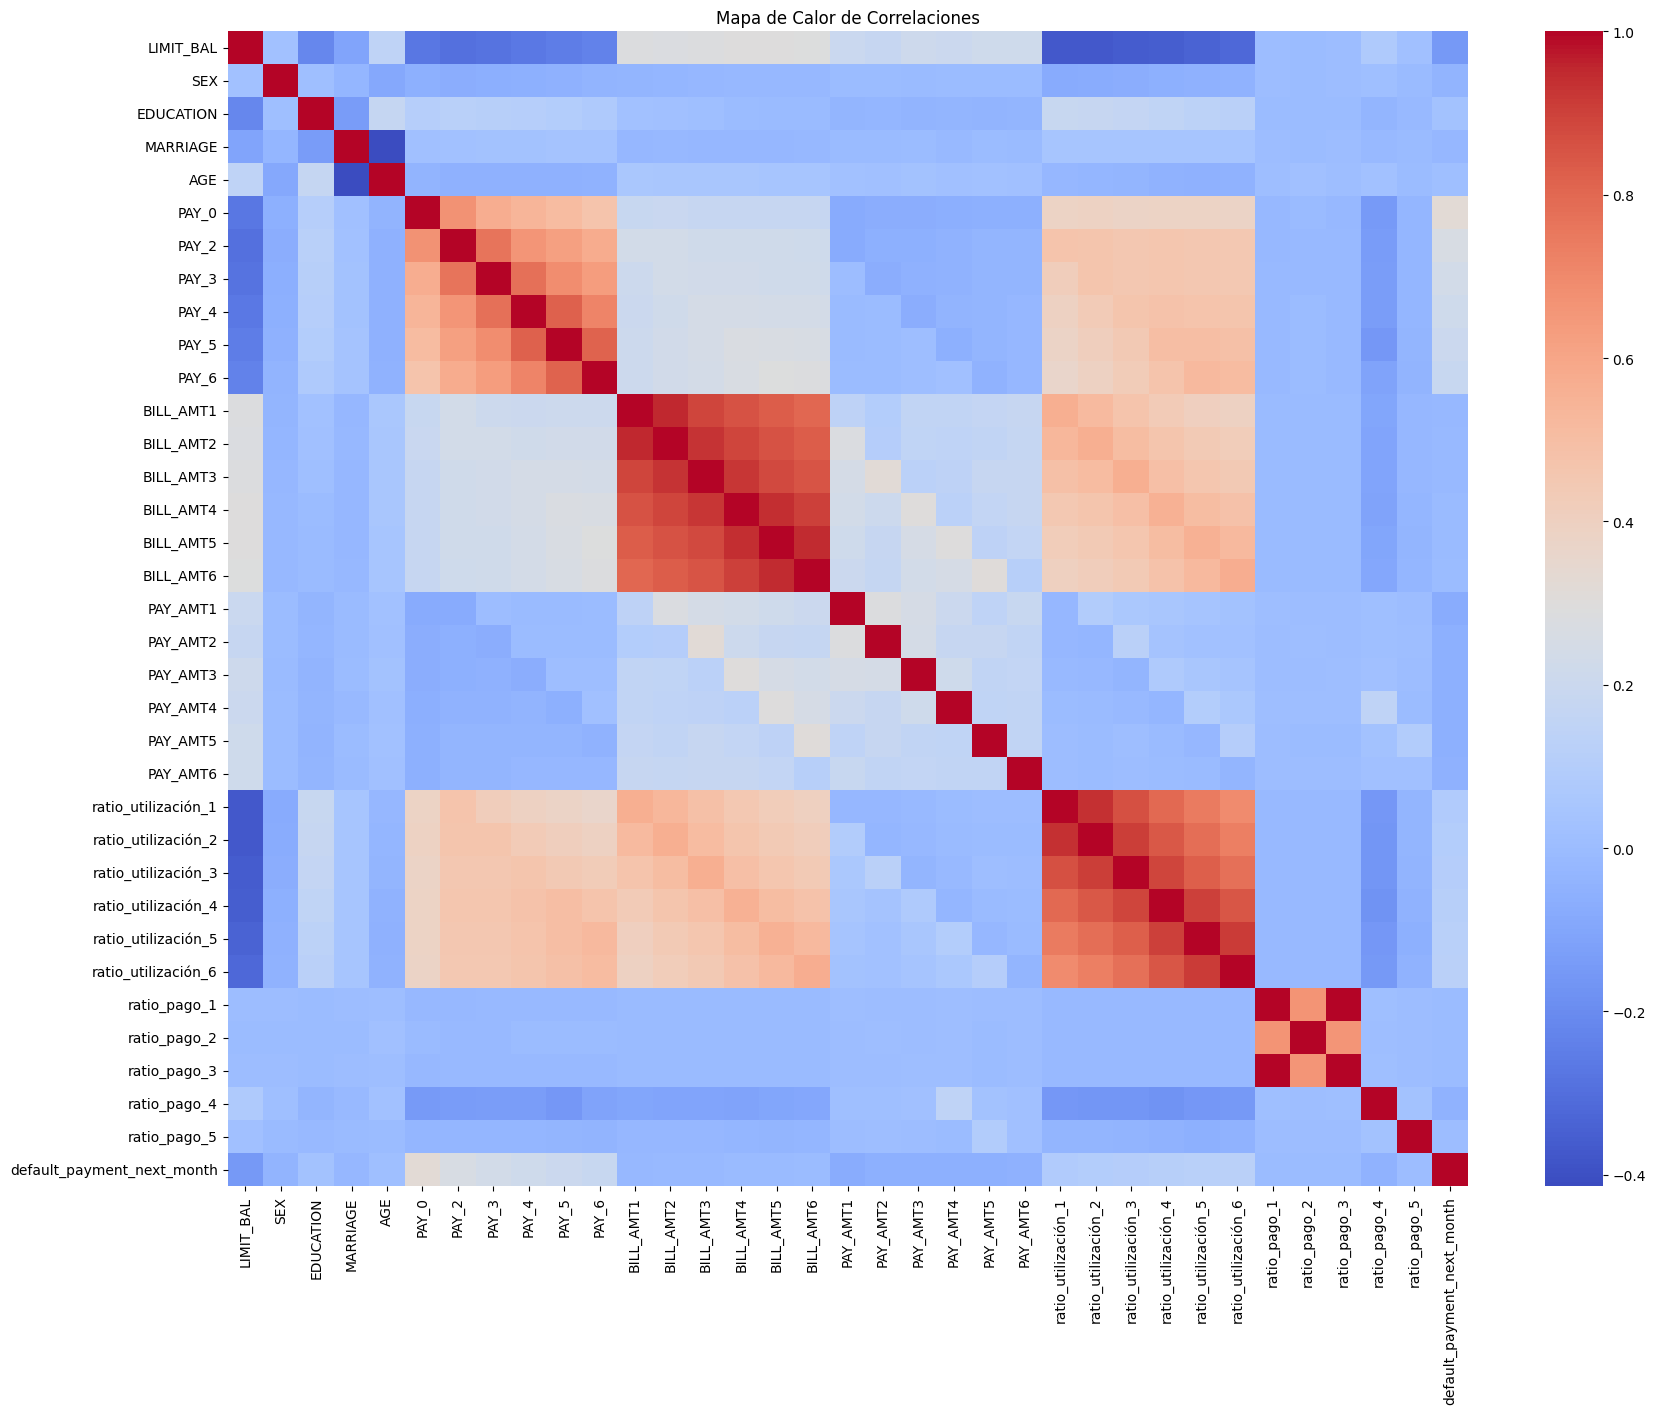

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='default_payment_next_month', data=df)
plt.title('Distribución de Clientes (0: No Default, 1: Default)')
plt.show()

# 2. Mapa de calor de correlaciones
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()


Se puede apreciar que hay un desbalance, si bien no es muy extremo, es lo suficientemente destacable como para tomarlo en cuenta para los parámetros que se usarán en los modelos.

Además, se puede ver que en el mapa de calor hay una fuerte correlación entre las características del grupo "PAY" y el grupo "BILL". Pero esto cobrará relevancia más adelante, en las explicaciones posteriores.

# Definición de variables X e Y

In [6]:
X = df.copy()
X = X.drop(columns = {"default_payment_next_month"}, axis = 1)
y = df["default_payment_next_month"]

# Separación entre grupos de entrenamiento y pruebas

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    test_size = 0.25, 
                                                    random_state = 20)

# Preparación de entrenamiento con Optuna

He optado por usar optuna para entrenar el modelo XGBoost, el principal motivo es que es relativamente rápido y eficiente, ya que su trabajo es "aprender" de los resultados anteriores y ver qué parametros son más relevantes para obtener los mejores resultados. En lo que respecta a su aprendizaje, tendrá como tarea maximizar la métrica de "**roc_auc**", esto tendrá más relevancia más adelante.

In [11]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_jobs': -1,
        'random_state': 20,
        'tree_method': 'hist',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
    }

    
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    param['scale_pos_weight'] = scale_pos_weight

    
    model = xgb.XGBClassifier(**param)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    
    return np.mean(score)

study = optuna.create_study(direction='maximize')


optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=100, timeout=600)

best_params = study.best_trial.params

## Visualización de su aprendizaje

El modelo trabaja en base a varios intentos en los que busca parámetros de forma aleatoria, pero que de a poco aprende cuál es la combinación que da mejores resultados en base a la tarea que le dí. Dicho esto, se puede aprecia que al principio solía dar resultados más bien azarosos, pero conforme fue aprendiendo, sus intentos se iban volviendo más y más constantes.

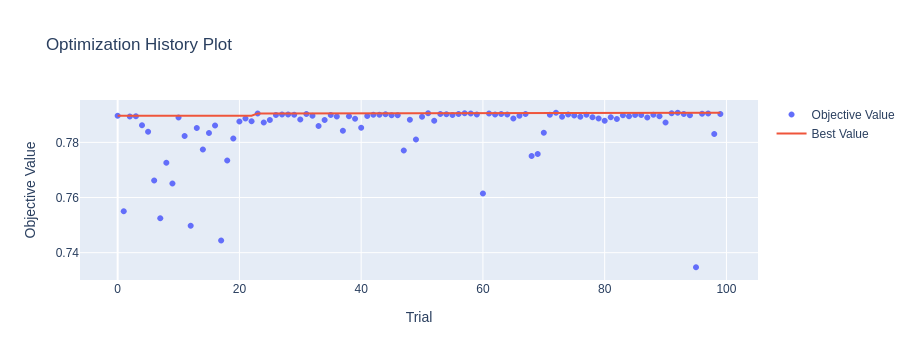

In [12]:
optuna.visualization.plot_optimization_history(study)

## Preparación del modelo optimizado
Luego de determinar la mejor combinación de parámetros, se guardará esa combinación y se pondrá a prueba.

In [13]:
final_model = xgb.XGBClassifier(**best_params)

In [14]:
final_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9538492542631211
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


# Evaluación Modelo XGBoost

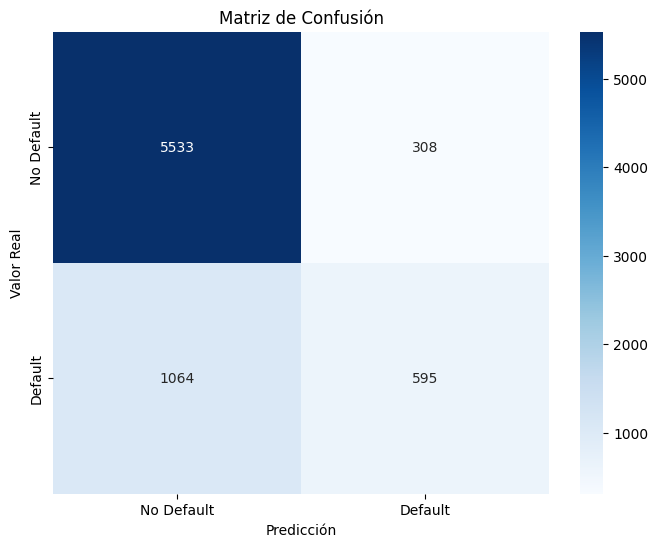


Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.66      0.36      0.46      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [15]:
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación")
print(classification_report(y_test, y_pred))

## Explicación de métricas
"Precision" se usa para medir la proporción entre los verdaderos positivos y todas las predicciones de positivos (verdaderos positivos y falsos positivos). Dicho esto, nos dice que el 67% de las veces el modelo predecirá que un cliente iría a default y realmente se irá a default. Por lo tanto, más de la mitad de las veces se presentarán casos en los que el modelo determinará que un cliente irá a default y sí habrá sido así realmente.

En cambio, "Recall" se usa para medir la proporción entre verdaderos positivos y todas las predicciones que deberían ser positivos (verdaderos positivos y falsos negativos), siendo en este caso un 36%, por lo tanto, el modelo es más bien ineficiente a la hora de detectar los clientes que realmente se irán a default, lo cual es bastante importante.

Finalmente, "f1_score" sirve para tener una idea general del rendimiento del modelo, esto se debe a que es la media harmónica entre las métricas recién mencionadas, sin embargo, creo que es más importante para este caso concentrarnos en las dos anteriores.

## Correción de umbral

Ya que la precisión es considerablemente más alta que el recall, puede ser buena idea cambiar un cierto **umbral**, lo relevante de este umbral es que me permite modificar el grado de permisividad que tendrá el modelo. El valor base es 0.5, pero si lo bajo podría ser menos riguroso con los valores que predice como positivo, pero a cambio sería más riguroso con los valores que deberían ser verdaderos.

El motivo por el cual se escogió la métrica "roc_auc", es porque es una forma de decir que busque un modelo que funcione bien sin importar el umbral, para así poder definirlo posteriormente y ver cuál sería el óptimo según el caso.

In [16]:
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

nuevo_umbral = 0.26

y_pred_nuevo = (y_pred_proba >= nuevo_umbral).astype(int)

print(f"Resultados con umbral de {nuevo_umbral}")
print(classification_report(y_test, y_pred_nuevo))

Resultados con umbral de 0.26
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      5841
           1       0.49      0.56      0.52      1659

    accuracy                           0.77      7500
   macro avg       0.68      0.70      0.69      7500
weighted avg       0.79      0.77      0.78      7500



## Umbral óptimo

Después de experimentar un poco con valores, determiné que lo más ideal es aumentar el valor de recall, ya que es más importante detectar la mayor cantidad de personas posible que realmente no pagarán su próxima cuota. Sin embargo, tampoco es buena idea dejar un valor de precisión demasiado bajo, porque de ese modo saldrían demasiadas predicciones de clientes que no pagarán cuando realmente si iban a pagar. Considero que 50% es lo mínimo que debería de tener un modelo en precisión.

## Explicación del modelo (SHAP)
Para evitar los problemas de explicabilidad que conlleva usar XGBoost, usaré SHAP para buscar una mejor explicación acerca de las columnas más relevantes para el modelo. 

En primer lugar, usaré un gráfico "Beeswarm" para mostrar el impacto de las características en la predicción de cada observación.

Finalmente, usaré un gráfico de barras para mostrar la importancia de cada característica de forma global.

# Nuevo Modelo
Ya que no se han podido obtener resultados satisfactorios, es momento de probar con otro modelo y comparar. En este caso, optaré por usar un **Random Forest Classifier**.

## Importar módulos

In [17]:
from sklearnex import patch_sklearn # Solo importar esto si se tiene un procesador Intel
patch_sklearn() # Si no se cumple el requisito mencionado, entonces es mejor borrar esta sección.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # Usaré esta búsqueda de parámetros porque el parche recién instalado acelera muchísimo el código, de otro modo, sería buena idea usar otra forma de mejorar los parámetros.

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## Definición de parámetros

In [18]:
parámetros = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 4],
    "max_features": ["sqrt", "log2"]
}

## Instanciar modelo

In [19]:
rf_classifier = RandomForestClassifier(
    class_weight='balanced',
    random_state=20,
    n_jobs=-1
)

grid_search_rf = GridSearchCV(estimator=rf_classifier,
                              param_grid=parámetros,
                              scoring='roc_auc', 
                              cv=5,               
                              verbose=1,
                              n_jobs=-1)


## Entrenar el modelo

In [20]:
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,estimator,RandomForestC...ndom_state=20)
,param_grid,"{'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 4], 'min_samples_split': [2, 5], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


## Evaluar el modelo

Para evaluar el modelo, aplicaremos los mismos pasos que con el anterior, una matriz de confusión y luego una evaluación de sus métricas "precision", "recall" y "f1_score".

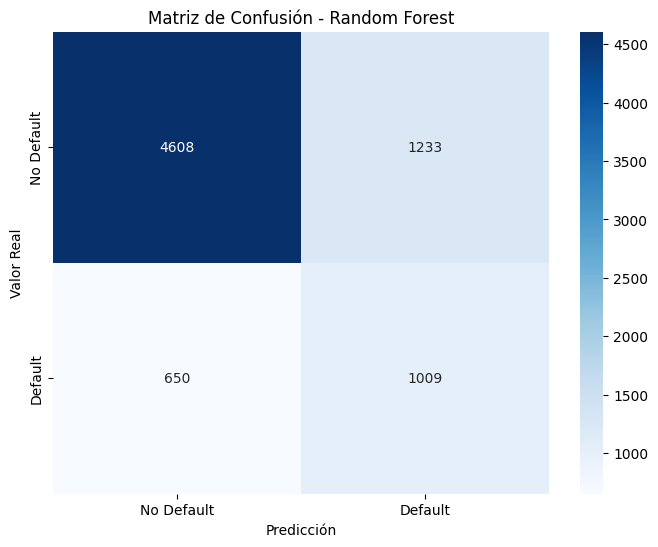

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      5841
           1       0.45      0.61      0.52      1659

    accuracy                           0.75      7500
   macro avg       0.66      0.70      0.67      7500
weighted avg       0.78      0.75      0.76      7500



In [21]:
y_pred_rf = grid_search_rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

print(classification_report(y_test, y_pred_rf))

# Experimentar con un nuevo umbral

La precisión es un poco baja y recall está bien, pero si subo un poco el umbral podría obtener un resultado más equilibrado.

In [22]:
y_pred_proba_rf = grid_search_rf.predict_proba(X_test)[:, 1]

nuevo_umbral = 0.55

y_pred_nuevo_rf = (y_pred_proba_rf >= nuevo_umbral).astype(int)

print(f"Resultados con umbral de {nuevo_umbral}")
      
print(classification_report(y_test, y_pred_nuevo_rf))

Resultados con umbral de 0.55
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      5841
           1       0.50      0.56      0.53      1659

    accuracy                           0.78      7500
   macro avg       0.68      0.70      0.69      7500
weighted avg       0.79      0.78      0.78      7500



## Explicación del nuevo modelo

Usaré los mismos gráficos *beeswarm y barras* para explicar el modelo.

In [23]:
mejor_modelo = grid_search_rf.best_estimator_

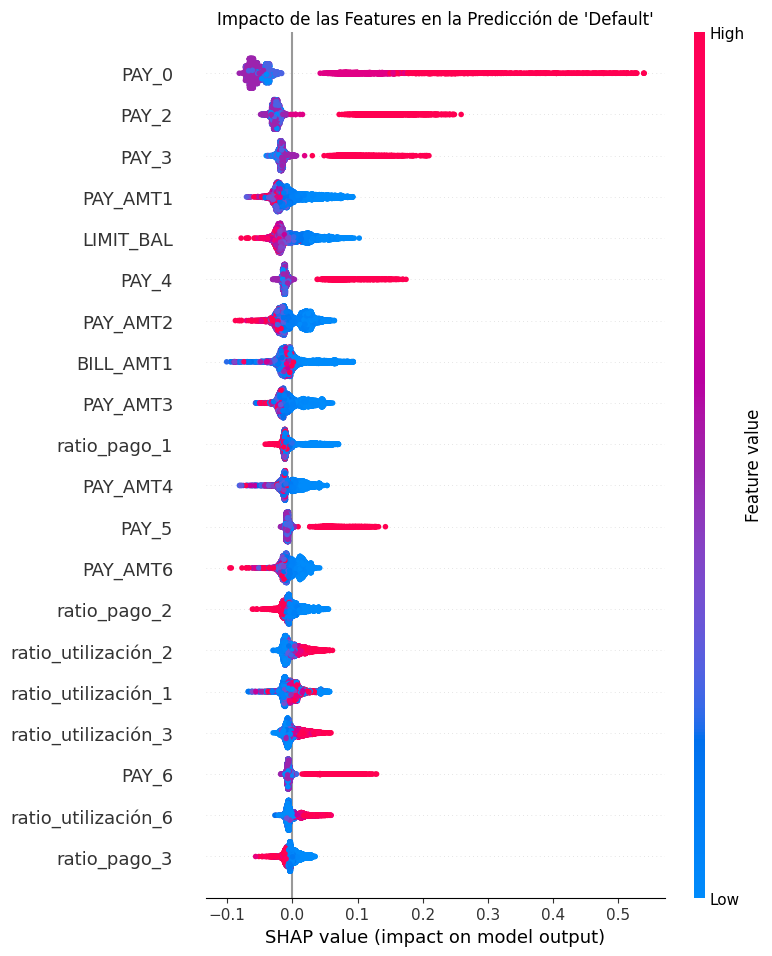

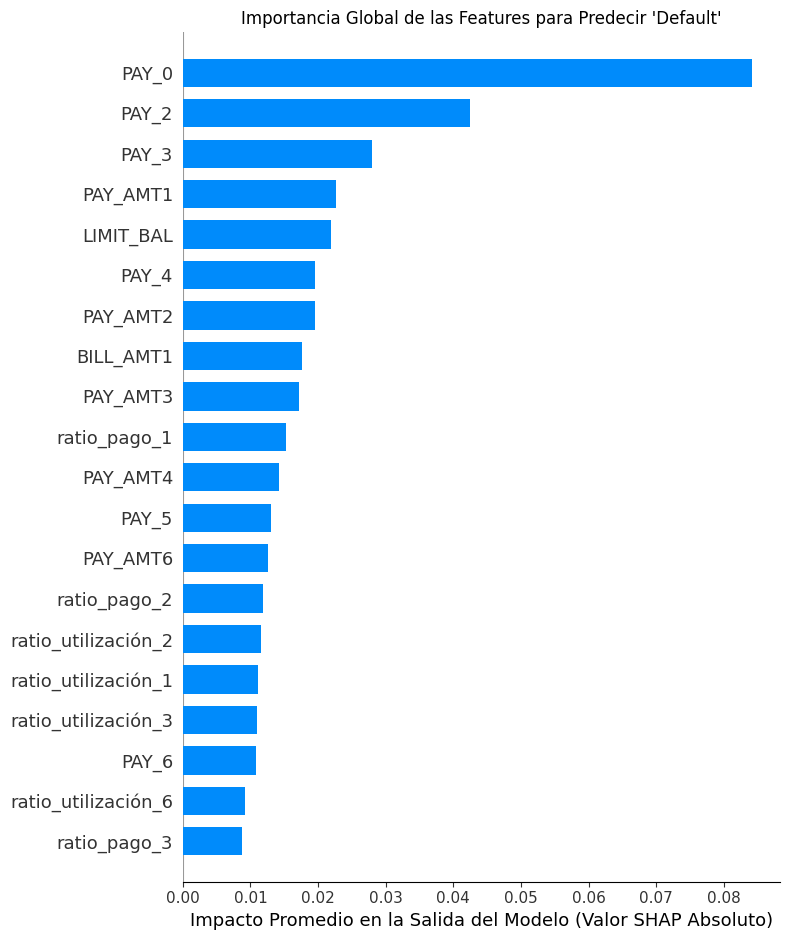

In [24]:
project_root = Path.cwd().parent
figures_path = project_root / "fig"

image_filename = 'shap_feature_importance.png'
image_path = figures_path / image_filename

explainer = shap.TreeExplainer(mejor_modelo)

shap_values = explainer(X_test)

shap_values_class_1 = shap_values[..., 1]

shap.summary_plot(shap_values_class_1, X_test, plot_type='dot', show=False)
plt.title("Impacto de las Features en la Predicción de 'Default'")
plt.show()

shap.summary_plot(shap_values_class_1, X_test, plot_type='bar', show=False)
plt.title("Importancia Global de las Features para Predecir 'Default'")

fig = plt.gcf()
fig.axes[-1].set_xlabel("Impacto Promedio en la Salida del Modelo (Valor SHAP Absoluto)")
plt.tight_layout()
plt.savefig(
    image_path,
    dpi=300,             
    bbox_inches='tight'  
)
plt.show()

# Impacto de variables

Según lo visto en el mapa de calor, las características que comparten una alta correlación están con un nivel de importancia más bien similar, esto es normal, ya que el modelo tenderá a darles la misma importancia predictiva. Sin embargo, cabe destacar que las características "PAY_0" y "PAY_2" son demasiado destacadas por encima del resto como para confundirlas. Por lo tanto, el foco de interés debiese caerles encima sin importar lo mencionado previamente.

# Guardar modelo
Ya que efectivamente se pudo obtener un resultado más balanceado, es importante guardar el modelo.

In [25]:
project_root = Path.cwd().parent

carp_pkl = project_root / "pkl"

carp_pkl.mkdir(exist_ok=True, parents = True)

mejor_modelo_path = carp_pkl / "mejor_modelo_rf.pkl"

grid_search_path = carp_pkl / "grid_search_rf_resultados.pkl"

with open(mejor_modelo_path, 'wb') as f:
        pickle.dump(mejor_modelo, f)

with open(grid_search_path, 'wb') as f:
        pickle.dump(grid_search_rf, f)

# Conclusión

En este proyecto:
- Revisamos el desbalance de los datos.
- Visualizamos las características e investigamos las relaciones (correlación) entre las características.
- Después revisamos dos modelos de Machine Learning para ver cuál sería más apropiado para detectar el default de los clientes.
- Se concluyó que el más apropiado sería el de Random Forest Classifier, ya que obtuvo los resultados más balanceados y que permite detectar la mayor cantidad de defaults que de verdad lo irían a ser, sin necesidad de caer demasiado en falsos positivos.